In [1]:
using TuringModels
gr(size=(500,500));

Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false)

ProjDir = rel_path_t("..", "scripts", "04")
cd(ProjDir)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/r03H1/src/Turing.jl:24


### snippet 4.43

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults and center the weight observations

In [3]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight]);
df2[:weight_c] = df2[:weight] .- mean_weight;
first(df2, 5)

,height,weight,age,male,weight_c
,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64
1,151.765,47.8256,63.0,1,2.83512
2,139.7,36.4858,63.0,0,-8.50468
3,136.525,31.8648,65.0,0,-13.1256
4,156.845,53.0419,41.0,1,8.05143
5,145.415,41.2769,51.0,0,-3.71361


Extract variables for Turing model

In [4]:
y = convert(Vector{Float64}, df2[:height]);
x = convert(Vector{Float64}, df2[:weight_c]);

Define the regression model

In [5]:
@model line(y, x) = begin
    #priors
    alpha ~ Normal(178.0, 100.0)
    beta ~ Normal(0.0, 10.0)
    s ~ Uniform(0, 50)

    #model
    mu = alpha .+ beta*x
    for i in 1:length(y)
      y[i] ~ Normal(mu[i], s)
    end
end;

Draw the samples

In [6]:
samples = 2000
adapt_cycles = 1000

@time chn = sample(line(y, x), Turing.NUTS(samples, adapt_cycles, 0.65));
draws = adapt_cycles+1:samples;

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 0.1
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:235
┌ Info:  Adapted ϵ = 0.042988102628502785, std = [1.0, 1.0, 1.0]; 1000 iterations is used for adaption.
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/r03H1/src/inference/adapt/adapt.jl:91
[NUTS] Finished with
  Running time        = 185.48730016900032;
  #lf / sample        = 0.0;
  #evals / sample     = 21.478;
  pre-cond. metric    = [1.0, 1.0, 1.0].
186.594360 seconds (1.41 G allocations: 92.573 GiB, 20.59% gc time)


Correct NUTS chain (drop adaptation samples)

In [7]:
chn2 = Chains(chn[draws,:,:], :parameters)

Object of type Chains, with data of type 1000×3×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1001:2000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
parameters        = alpha, s, beta

parameters
        Mean     SD   Naive SE  MCSE     ESS   
alpha 154.5831 0.2563   0.0081 0.0184  194.4919
 beta   0.9053 0.0426   0.0013 0.0011 1000.0000
    s   5.1184 0.2044   0.0065 0.0062 1000.0000



Look at the proper draws (in corrected chn2)

In [8]:
describe(chn2)

Log evidence      = 0.0
Iterations        = 1001:2000
Thinning interval = 1
Chains            = Chain1
Samples per chain = 1000
parameters        = alpha, s, beta

Empirical Posterior Estimates
──────────────────────────────────────────────────
parameters
        Mean     SD   Naive SE  MCSE     ESS   
alpha 154.5831 0.2563   0.0081 0.0184  194.4919
 beta   0.9053 0.0426   0.0013 0.0011 1000.0000
    s   5.1184 0.2044   0.0065 0.0062 1000.0000

Quantiles
──────────────────────────────────────────────────
parameters
        2.5%     25.0%    50.0%    75.0%    97.5% 
alpha 153.5042 154.4292 154.5826 154.7559 155.3139
 beta   0.7824   0.8751   0.9053   0.9352   1.0312
    s   4.6020   4.9813   5.1048   5.2459   5.8837



Compare with a previous result

In [9]:
clip_43s_example_output = "

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
alpha 154.597086 0.27326431 0.0043206882 0.0036304132 1000
 beta   0.906380 0.04143488 0.0006551430 0.0006994720 1000
sigma   5.106643 0.19345409 0.0030587777 0.0032035103 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 154.0610000 154.4150000 154.5980000 154.7812500 155.1260000
 beta   0.8255494   0.8790695   0.9057435   0.9336445   0.9882981
sigma   4.7524368   4.9683400   5.0994450   5.2353100   5.5090128
";

Plot the chains

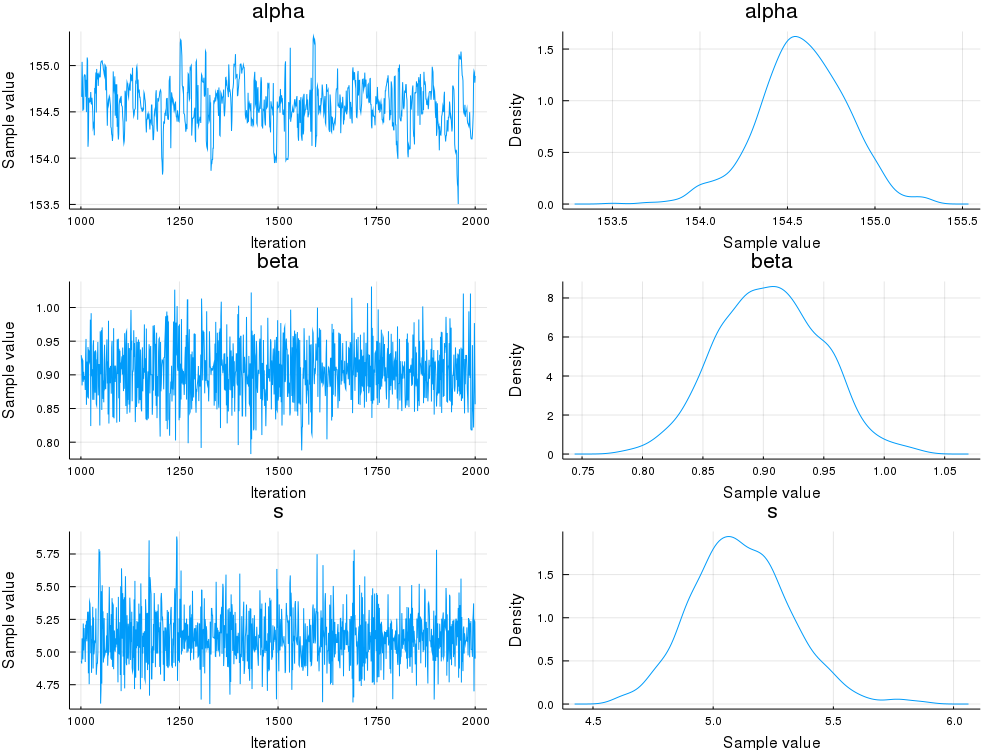

In [10]:
plot(chn2)

Plot the regerssion line and observations

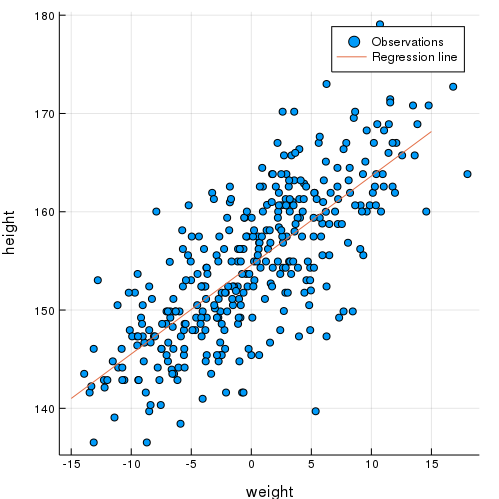

In [11]:
scatter(x, y, lab="Observations", xlab="weight", ylab="height")
xi = -15.0:0.1:15.0
yi = mean(chn2[:alpha]) .+ mean(chn2[:beta])*xi
plot!(xi, yi, lab="Regression line")

End of `04/m4.2t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*